c:\ProgramData\anaconda3\envs\cea\lib\site-packages\IPython\core\interactiveshell.py:3448: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


The result has been saved to 'buildings_within_blocks.csv'. Here is a preview:
                                             geometry  \
47  POLYGON ((384976.272 5820790.551, 384977.076 5...   
48  POLYGON ((384977.076 5820789.909, 384980.900 5...   
49  POLYGON ((384980.900 5820786.855, 384979.470 5...   
50  POLYGON ((384979.470 5820786.297, 384974.776 5...   
51  POLYGON ((384974.776 5820780.350, 384974.342 5...   

                                       gml_id  index_right   blknr bez  \
47  UUID_c4da567a-8e82-4786-998b-b1844cbc20ad           28  020050  04   
48  UUID_58df1d83-84aa-4422-bc1c-6d02f0a67787           28  020050  04   
49  UUID_dcc8e14b-52e0-43ab-9745-fbc404fe980f           28  020050  04   
50  UUID_b567dd6f-fbc8-412a-9b05-82d30ac506ac           28  020050  04   
51  UUID_c0e2a102-56fa-4660-a007-ee292aedb0ee           28  020050  04   

                       bezname       plr blktypname                ewk  \
47  Charlottenburg-Wilmersdorf  04300518      Block  100-99

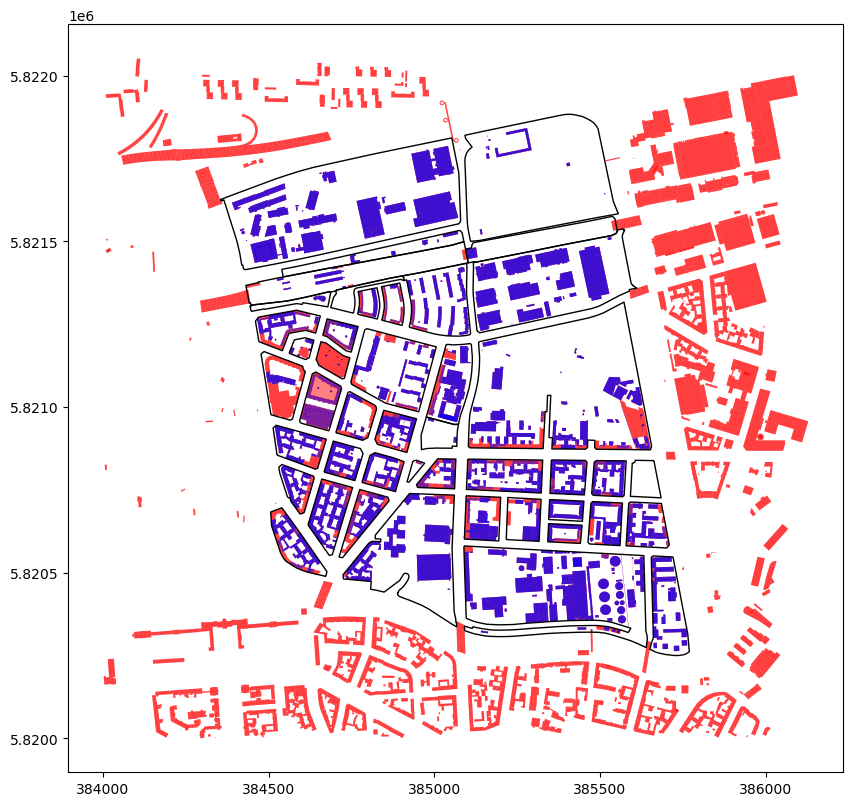

In [20]:
import os
import geopandas as gpd
import pandas as pd
import lxml.etree as ET
import shapely.geometry as geom
import matplotlib.pyplot as plt

# Load shapefile
shapefile_path = r"C:\Users\felix\Programmieren\cea_berlin\auxillary\00_block_shape.shp"
blocks_gdf = gpd.read_file(shapefile_path)

# Load and parse the GML file
gml_files = ["LoD2_33_384_5820_1_BE.xml", "LoD2_33_384_5821_1_BE.xml", "LoD2_33_385_5820_1_BE.xml", "LoD2_33_385_5821_1_BE.xml"]




# Define the namespaces (you may need to adjust these based on your GML file)
ns = {
    'gml': 'http://www.opengis.net/gml',
    'bldg': 'http://www.opengis.net/citygml/building/2.0'
}

# Extract building geometries
def extract_polygons(gml_root):
    buildings = []

    # Extract posList geometries
    for bldg in gml_root.findall('.//bldg:Building', ns):
        for geom_elem in bldg.findall('.//gml:posList', ns):
            pos_list = geom_elem.text.split()
            if len(pos_list) % 3 != 0:
                print(f"Warning: posList does not contain triplets of coordinates: {pos_list}")
                continue
            try:
                coords = [(float(pos_list[i]), float(pos_list[i+1])) for i in range(0, len(pos_list), 3)]
                polygon = geom.Polygon(coords)
                buildings.append(polygon)
            except Exception as e:
                print(f"Error creating polygon for posList {pos_list}: {e}")

    # Extract Polygon geometries
    for poly in gml_root.findall('.//gml:Polygon', ns):
        pos_list = poly.find('.//gml:posList', ns)
        if pos_list is not None:
            pos_list = pos_list.text.split()
            if len(pos_list) % 3 != 0:
                print(f"Warning: posList does not contain triplets of coordinates: {pos_list}")
                continue
            try:
                coords = [(float(pos_list[i]), float(pos_list[i+1])) for i in range(0, len(pos_list), 3)]
                polygon = geom.Polygon(coords)
                buildings.append(polygon)
            except Exception as e:
                print(f"Error creating polygon for posList {pos_list}: {e}")

    return buildings

list_buildings = []
for gml_file in gml_files:
    module_path = os.path.abspath(os.path.join('..'))
    gml_file_path = os.path.join(module_path, 'data', 'examples', 'gml_data', gml_file)
    #c:\Users\felix\Programmieren\TECDEM\experiments\data\examples\gml_data\gml_data\LoD2_33_384_5820_1_BE.xml
    #C:\Users\felix\Programmieren\TECDEM\data\examples\gml_data\LoD2_33_384_5820_1_BE.xml
    #c:\Users\felix\Programmieren\TECDEM\data\examples\gml_data\gml_data\LoD2_33_384_5820_1_BE.xm 
    tree = ET.parse(gml_file_path)
    root = tree.getroot()
    buildings = extract_polygons(root)
    list_buildings.extend(buildings)

# Check if we have extracted any buildings
if not buildings:
    print("No buildings were extracted from the GML file.")
else:
    # Convert to GeoDataFrame
    buildings_gdf = gpd.GeoDataFrame(geometry=list_buildings, crs=blocks_gdf.crs)

    # Check if buildings are within blocks
    within_blocks = gpd.sjoin(buildings_gdf, blocks_gdf, how='inner', op='within')

    # Save the result to a CSV file
    aux_path = os.path.join(module_path, 'data', 'examples', 'gml_data', 'buildings_within_blocks.csv')
    within_blocks.to_csv(aux_path, index=False)
    print("The result has been saved to 'buildings_within_blocks.csv'. Here is a preview:")
    print(within_blocks.head())

    # Optional: Plotting the results for visual inspection
    fig, ax = plt.subplots(figsize=(10, 10))
    blocks_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
    buildings_gdf.plot(ax=ax, color='red', alpha=0.5)
    within_blocks.plot(ax=ax, color='blue', alpha=0.5)
    plt.show()



In [ ]:
# Extract building geometries along with their IDs
def extract_polygons_with_ids(gml_root):
    buildings = []

    # Extract posList geometries
    for bldg in gml_root.findall('.//bldg:Building', ns):
        bldg_id = bldg.get('{http://www.opengis.net/gml}id')
        for geom_elem in bldg.findall('.//gml:posList', ns):
            pos_list = geom_elem.text.split()
            if len(pos_list) % 3 != 0:
                print(f"Warning: posList does not contain triplets of coordinates: {pos_list}")
                continue
            try:
                coords = [(float(pos_list[i]), float(pos_list[i+1])) for i in range(0, len(pos_list), 3)]
                polygon = geom.Polygon(coords)
                buildings.append({'geometry': polygon, 'gml_id': bldg_id})
            except Exception as e:
                print(f"Error creating polygon for posList {pos_list}: {e}")

    # Extract Polygon geometries
    for poly in gml_root.findall('.//gml:Polygon', ns):
        bldg_id = poly.get('{http://www.opengis.net/gml}id')
        pos_list = poly.find('.//gml:posList', ns)
        if pos_list is not None:
            pos_list = pos_list.text.split()
            if len(pos_list) % 3 != 0:
                print(f"Warning: posList does not contain triplets of coordinates: {pos_list}")
                continue
            try:
                coords = [(float(pos_list[i]), float(pos_list[i+1])) for i in range(0, len(pos_list), 3)]
                polygon = geom.Polygon(coords)
                buildings.append({'geometry': polygon, 'gml_id': bldg_id})
            except Exception as e:
                print(f"Error creating polygon for posList {pos_list}: {e}")

    return buildings

list_buildings = []
for gml_file in gml_files:
    module_path = os.path.abspath(os.path.join('..'))
    gml_file_path = os.path.join(module_path, 'data', 'examples', 'gml_data', gml_file)
    tree = ET.parse(gml_file_path)
    root = tree.getroot()
    buildings = extract_polygons_with_ids(root)
    list_buildings.extend(buildings)  # Use extend to flatten the list

# Check if we have extracted any buildings
if not list_buildings:
    print("No buildings were extracted from the GML files.")
else:
    # Convert to GeoDataFrame
    buildings_gdf = gpd.GeoDataFrame(list_buildings, crs=blocks_gdf.crs)

    # Check if buildings are within blocks
    within_blocks = gpd.sjoin(buildings_gdf, blocks_gdf, how='inner', op='within')

    # Save the result to a CSV file
    within_blocks.to_csv(r'C:\Users\felix\Programmieren\cea_berlin\auxillary\buildings_within_blocks.csv', index=False)
    print("The result has been saved to 'buildings_within_blocks.csv'. Here is a preview:")
    print(within_blocks.head())

    # Optional: Plotting the results for visual inspection
    fig, ax = plt.subplots(figsize=(10, 10))
    blocks_gdf.boundary.plot(ax=ax, linewidth=1, edgecolor='black')
    buildings_gdf.plot(ax=ax, color='red', alpha=0.5)
    within_blocks.plot(ax=ax, color='blue', alpha=0.5)
    plt.show()